# Installation of external packages

In [ ]:
!pip install qflux

# Standard imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
from tqdm.notebook import trange

# Constants and unit conversion factors

In [ ]:
au2ev = 27.21138602
ev2au = 1/au2ev
bohr2au = 0.52917721092
au2bohr = 1/bohr2au
fs2au = 41.3414
au2fs = 1/fs2au

mass_proton = 1836.15 # proton mass in units of electron mass

# 3. Workflow for Quantum Dynamics Simulations

## 3.1. Quantum Dynamics of a Harmonic Oscillator

### QuTiP propagation of the coherent state in harmonic potential

Before we look at doing Quantum Dynamics on a quantum computer, we'll start out by looking at some ways that we can do quantum dynamics on a classical computer! This is an important step as it will familiarize you with the general ingredients of a quantum dynamics simulation and will also provide us with a means of validating the results obtained from a quantum computer.

We begin by showing a simple example of how to compute dynamics of an initial state using QuTiP's mesolve() function. When we run dynamics, we must do the following:

1. **Define the initial state** $\left| \alpha \right\rangle$. In this example, our initial state is defined as a coherent state with amplitude $\alpha = x_{0} + i p_{0}$, which can be expressed in the Fock Basis as:
     
    $$ \left| \alpha \right\rangle = \sum_{n=0}^\infty\frac{\alpha^{n}}{\sqrt{n!}} e^{-\frac{1}{2}\left| \alpha \right|^{2}} \left| n \right\rangle $$
     
2. **Define the Hamiltonian** $H$. In this example, our Hamiltonian is the familiar quantum harmonic oscillator Hamiltonian, defined in terms of creation and annihilation operators as:

$$ H =  \hbar \omega \left( \hat{a}^{\dagger} \hat{a} + \frac{1}{2} \right) $$

3. **Define the propagation time step $t$ and the number of time steps $n$ for which to compute the wavefunction.**

4. **Compute the time-evolved wavefunction at each step as:**

$$ \left| \alpha (t_{i+1}) \right\rangle = e^{-\frac{i}{\hbar} H t} \left| \alpha(t_{i}) \right\rangle $$

<!-- **Note:** For a coherent state, the time evolution within the harmonic oscillator takes the form of:

$$  \begin{align*}
        \left| \psi (t) \right\rangle &= e^{-\frac{1}{2} \left| \alpha \right|^{2}} \sum_{n=0}^{\infty} \frac{\alpha_{0}^{n}}{\sqrt{n!}} e^{- i \omega \left( n + \frac{1}{2} \right) t} \left| n \right\rangle \\
                                      &= e^{- i \omega t /2} e^{-\frac{1}{2} \left| \alpha \right|^{2}} \sum_{n=0}^{\infty} \frac{\left( \alpha_{0} e^{- i \omega t} \right)^{n}}{\sqrt{n!}} \left| n \right\rangle \\
    \end{align*}
$$ -->


In [ ]:
import qutip as qt

# Define the System Parameters:
mass = 1     # mass = 1.0
hbar = 1     # hbar = 1.0
omega = 1.0  # Oscillator frequency

# Initial State: coherent state with amplitude \alpha=(x_0 + i p_0)/\sqrt{2}
x_0 = 1.00   # Initial Position
p_0 = 0.00   # Initial Momentum
N = 128 # Number of States in Fock Basis
psi_0 = qt.coherent(N, alpha=(x_0 + 1.j*p_0)/np.sqrt(2))

# Define the propagation time array with n_steps from 0 to total_time
n_steps = 400   # Number of time steps
total_time = 20 # Total Propagation time
# Define the list of times for which we calculate dynamics.
tlist = np.linspace(0, total_time, n_steps)

# Construct the Hamiltonian:
a = qt.destroy(N)  # Annihilation operator
H_ho = hbar*omega*(a.dag()*a + 1./2.)   # Harmonic Oscillator Hamiltonian

# Set up the Solver and Run dynamics!
solver_options = {'nsteps': len(tlist), 'progress_bar': True}
result = qt.sesolve(H_ho, psi_0, tlist, [], [], options=solver_options)

### Plotting Expectation Values

<!-- One of the useful things we can do with the result of our quantum dynamics calculation is compute expectation values.

For example, we can consider some expectation values of our initial states:

Recall that: $\hat{a} | \alpha\ \rangle = \alpha | \alpha \rangle \ \ \ \textrm{ and } \ \ \ \langle \alpha | \hat{a}^{\dagger} = \alpha^{*} \langle \alpha |$


Then the expected position of our initial state can be computed as:


\begin{split}
\left \langle \hat{X} \right \rangle & = \left \langle \alpha \middle| \frac{1}{\sqrt{2}} \left( \hat{a} + \hat{a}^{\dagger} \right) \middle| \alpha \right \rangle \\
& = \frac{1}{\sqrt{2}} \left( \left \langle \alpha \middle| \hat{a} \middle| \alpha \right \rangle + \left \langle \alpha \middle| \hat{a}^{\dagger} \middle| \alpha \right \rangle \right) \\
& = \frac{1}{\sqrt{2}} \left( \alpha + \alpha^{*} \right) \\
& = \sqrt{2}  \ \mathbf{Re}\left[ \alpha \right]
\end{split}

We can do the same for the momentum:

\begin{split}
\left \langle \hat{P} \right \rangle & = \frac{- i \hbar}{\sqrt{2}} \left \langle \alpha \middle| \left( \hat{a} - \hat{a}^{\dagger} \right) \middle| \alpha \right \rangle \\
& = \frac{- i \hbar}{\sqrt{2}} \left( \left \langle \alpha \middle| \hat{a} \middle| \alpha \right \rangle - \left \langle \alpha \middle| \hat{a}^{\dagger} \middle| \alpha \right \rangle \right) \\
& = \frac{- i \hbar}{\sqrt{2}} \left( \alpha - \alpha^{*} \right) \\
& = \sqrt{2} \hbar \ \mathbf{Im} \left[ \alpha \right]
\end{split} -->

In [ ]:
X_op = (a.dag() + a)/np.sqrt(2)
P_op = 1j*(a.dag() - a)/np.sqrt(2)

exp_x_qt = qt.expect(X_op, result.states)
exp_p_qt = qt.expect(P_op, result.states)

exp_x_ana = []
exp_p_ana = []
for t in tlist:
    exp_x_ana.append(x_0*np.cos(omega*t) + (p_0/mass/omega)*np.sin(omega*t))
    exp_p_ana.append(-x_0*omega*mass*np.sin(omega*t) + p_0*np.cos(omega*t))

In [ ]:
tlist = np.linspace(0, total_time, n_steps)
fig, ax = plt.subplots()
ax.plot(tlist, exp_x_ana, '-', color='blue', label='<x> analytical', zorder=0)
ax.plot(tlist[::4], exp_x_qt[::4], 'o', color='blue', label='<x> QuTiP', zorder=0, markeredgecolor='blue', fillstyle='full', markerfacecolor='white')
ax.plot(tlist, exp_p_ana, '-', color='red',label='<p> analytical', zorder=2)
ax.plot(tlist[::4], exp_p_qt[::4], 'o', color='red',label='<p> QuTip', zorder=2, markeredgecolor='red', fillstyle='full', markerfacecolor='white')
ax.axhline(-1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.set_xlabel('time, a.u.', fontsize=14)
ax.set_ylabel('Expectation value', fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-1.5,2.5)
plt.legend(fontsize=12,loc='upper center')
plt.show()

## 3.2. Split-Operator Fourier Transform (SOFT) Method

Here, we compute the time-evolution of a wavepacket defined in the position basis ($\psi(x)$) according to the Split-Operator Fourier Transform (SOFT) method. This differs slightly from the approach utilized in the last section in the following ways:

- As mentioned above, we will describe the wavefunction in terms of the position. To do this, we must define a closed range of positions $x$ and momenta $p$ and discretize over some finite number of points (analagous to the finite number of Fock states considered above).
- We will compute the time evolution as:
$$ \left| \psi (t) \right\rangle =  e^{- \frac{i}{\hbar} {H} t} \left| \psi(0) \right\rangle $$
Writing $H$ in terms of Kinetic and Potential energy $H = T + V$:
$$ \begin{align*}
        \left| \psi (t) \right\rangle &\approx \lim\limits_{N\to\infty} \left[e^{\frac{-ip^2t}{2m\hbar N}}\ e^{\frac{-i{V}({x})t}{\hbar N}}\right]^N \space |\psi(0)\rangle \\
                                  &\approx\lim\limits_{N\to\infty} \left[e^{\frac{-i{V}({x})t}{2\hbar N}}\space e^{\frac{-ip^2t}{2m\hbar N}}\space e^{\frac{-i{V}({x})t}{2\hbar N}}\right]^N \space |\psi(0)\rangle   
% Inserting closure and writing in the plane-wave basis:
%     \left| \psi (x, t) \right\rangle &= \int d x_0 \space \langle x_t | e^{\frac{-iĤt}{\hbar}} | x_0 \rangle \space \langle x_0 | \psi(0) \rangle
    \end{align*}
$$
    
Propagation for a single timestep is then:
$$\psi(x,\frac{t_{i+1}}{N}) =
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} e^{\frac{-iV(x)t}{2\hbar N}} }^\textrm{P.E. Propagator} \ \cdot \
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} \color{blue}   {\int \frac{dp}{\sqrt{2\pi\hbar}} \ e^{\frac{-ipx}{\hbar}}}}^\textrm{Inverse Fourier Transform} \ \cdot
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} \ e^{\frac{-ip^2t}{2m\hbar N}}}^\textrm{K.E. Propagator} \ \cdot \
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} \color{purple}{\int \frac{dx}{\sqrt{2\pi\hbar}} \ e^{\frac{ ipx}{\hbar}}}}^\textrm{Fourier Transform} \ \cdot \
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}}\ e^{\frac{-iV(x)t}{2\hbar N}} }^\textrm{P.E. Propagator} \ \cdot \ \psi(x,t_{i})
$$

The Fourier and inverse Fourier transforms are used to convert between the position and momentum basis. To translate the formula above, the algorithm will consist of 5 steps per iteration:

1. Apply a half step of the potential energy propagator to the initial state.
2. Fourier transform into the momentum basis.
3. Apply a full step of the kinetic energy propagator on the momentum basis.
4. Inverse Fourier transform back into the coordinate basis.
5. Apply the second half step of the potential energy propagator.

This is done with the following code:

```python
# SOFT propagation
def soft(psi,pot_prop,kin_prop):
    out=pot_prop*psi              # Apply P.E. propagator
    out=kin_prop*np.fft.fft(out)  # FT and apply K.E. propagator
    out=pot_prop*np.fft.ifft(out) # IFT and Apply P.E. propagator
    return out
```
Note that here we must define our coherent state in the coordinate representation:

$$ \psi_{0} = \left( \tfrac{m \omega}{\pi \hbar} \right)^{1/4} e^{- \tfrac{m \omega}{2 \hbar} \left( x - x_{0} \right)^{2} + \tfrac{i}{\hbar} p_{0} x } $$

### Grids in position and momentum spaces

### More functions

**Coherent state** for a harmonic oscillator in position representation:
$$
\langle{x}|\alpha\rangle = \psi^{(\alpha)}(x) =
\left(\dfrac{m\omega}{\pi\hbar}\right)^{1/4}
\exp\left[
 -\dfrac{m\omega}{2\hbar}
  \left(x - \sqrt{\dfrac{2\hbar}{m\omega}}\mathcal{Re}[\alpha]\right)^2
 +\dfrac{\text{i}}{\hbar}\sqrt{2m\omega\hbar}\mathcal{Im}[\alpha]x
  \right]
$$
where
$$
\langle x\rangle = \sqrt{\dfrac{2\hbar}{m\omega}}\,\mathcal{Re}[\alpha] \\
\langle p\rangle = \vphantom{\sqrt{\dfrac{2\hbar}{m\omega}}}\sqrt{2m\omega\hbar}\,\mathcal{Im}[\alpha]
$$

are the expectation values of the position and momentum, respectively.

**Probability density in position representation**:
$$
\rho(x) = \langle \psi|x\rangle\langle x|\psi\rangle = \psi^*(x)\,\psi(x)
$$

**Propagator (evolution operator)**:
$$
\hat{U}(\tau) = e^{-\frac{\text{i}}{\hbar}\hat{H}\tau}
$$

In [ ]:
def get_xgrid(xmin, xmax, N_pts):
    """Generate an evenly spaced position grid."""
    dx = (xmax - xmin)/N_pts
    xgrid = np.arange(-N_pts/2, N_pts/2)*dx
    return xgrid

def get_pgrid(xmin, xmax, N_pts, reorder=True):
    """Generate a momentum grid using FFT-compatible ordering."""
    dp = 2 * np.pi / (xmax-xmin)
    pmin = -dp * N_pts / 2
    pmax = dp * N_pts / 2
    plus_pgrid = np.linspace(0, pmax, N_pts//2+1)
    minus_pgrid = - np.flip(np.copy(plus_pgrid))
    if reorder:
        pgrid = np.concatenate((plus_pgrid[:-1], minus_pgrid[:-1]))
    else:
        pgrid = np.concatenate((minus_pgrid, plus_pgrid))
    return pgrid

def get_coherent_state(x, p_0, x_0, mass=1, omega=1, hbar=1):
    """Generate an initial coherent state wavefunction."""
    normalization = (mass*omega/np.pi/hbar)**(0.25)
    y = normalization*np.exp(-1*(mass*omega/hbar/2)*((x-x_0)**2)+1j*p_0*x/hbar)
    return y

xmin = -7.0
xmax = 7.0
N_pts = 128
mass = 1.0 # mass of the particle in units of electron mass

# frequency of the harmonic oscillator (in atomic units)
omega = 1.0

# grid preparation and spacing
xgrid = get_xgrid(xmin, xmax, N_pts)
dx = xgrid[1] - xgrid[0]
# Momentum Grid
pgrid = get_pgrid(xmin, xmax, N_pts, reorder=True)

# initial coherent state - ground state Gaussian centered at x_0 = 1
x_0 = 1.0
p_0 = 0.0
psi_0 = get_coherent_state(xgrid, p_0, x_0, mass, omega)

In [ ]:
def get_harmonic_potential(x, x_0=0.0, mass=1, omega=1):
    return mass * omega**2 * (x - x_0)**2 / 2

def get_kinetic_energy(p, mass=1):
    return  p**2/2/mass

# operators
Vx_harm = get_harmonic_potential(xgrid)
K_harm = get_kinetic_energy(pgrid, mass)

### SOFT propagation of a coherent state in harmonic potential

In [ ]:
def get_propagator_on_grid(operator_grid, tau, hbar=1):
    # operator_grid: a numpy array, expressing the operator on a grid
    # tau: the time step for propagation (in atomic units of time)
    return np.exp(-1.0j * operator_grid * tau / hbar)

def do_SOFT_propagation(psi, K_prop, V_prop):
    # np.fft.fft and np.fft.ifft requires specific ordering of outputs/inputs
    psi_t_position_grid = V_prop * psi
    psi_t_momentum_grid = K_prop * np.fft.fft(psi_t_position_grid, norm="ortho")
    psi_t = V_prop * np.fft.ifft(psi_t_momentum_grid, norm="ortho")
    return psi_t

tmin = 0.0
tmax = 20.0
N_tsteps = 400

# grid preparation and spacing
tgrid = np.linspace(tmin, tmax, N_tsteps)
tau = tgrid[1] - tgrid[0]

print("For ", tmax, " a.u. using a timestep of ",tau," a.u.")

V_prop = get_propagator_on_grid(Vx_harm/2, tau)
K_prop = get_propagator_on_grid(K_harm, tau)

propagated_states_harm = [psi_0]
psi_t = psi_0
for tstep_idx in trange(len(tgrid)):
    psi_t = do_SOFT_propagation(psi_t, K_prop, V_prop)
    propagated_states_harm.append(psi_t)

propagated_states_harm = np.array(propagated_states_harm)[:-1]

#### Position and momentum expectation values

In [ ]:
def position_expectation_value(xgrid, psi):
    dx = xgrid[1]-xgrid[0]
    return dx*np.real(np.sum(xgrid * np.conjugate(psi) * psi))

def momentum_expectation_value(dx,pgrid, psi):
    psip = np.fft.fft(psi)
    return dx*np.real(np.sum(pgrid * np.conjugate(psip) * psip))/len(psi)

avxgrid_harm_soft = [position_expectation_value(xgrid,propagated_states_harm[i]) for i in range(len(propagated_states_harm))]
dx = xgrid[1]-xgrid[0]
avpgrid_harm_soft = [momentum_expectation_value(dx,pgrid,propagated_states_harm[i]) for i in range(len(propagated_states_harm))]

avxgrid_harm_ana = [ x_0*np.cos(omega*t) + (p_0/mass/omega)*np.sin(omega*t) for t in tgrid]
avpgrid_harm_ana = [ -x_0*omega*mass*np.sin(omega*t) + p_0*np.cos(omega*t) for t in tgrid]

fig, ax = plt.subplots()
ax.plot(tgrid, avxgrid_harm_ana, '-', color='blue',label='<x> analytical', zorder=0)
ax.plot(tgrid[::4], avxgrid_harm_soft[::4], 'o', color='blue',label='<x> SOFT', zorder=0, markeredgecolor='blue', fillstyle='full', markerfacecolor='white')
ax.plot(tgrid, avpgrid_harm_ana, '-', color='red',label='<p> analytical')
ax.plot(tgrid[::4], avpgrid_harm_soft[::4], 'o', color='red',label='<p> SOFT', markeredgecolor='red', fillstyle='full', markerfacecolor='white', zorder=0)

ax.axhline(-1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.set_xlabel('time, a.u.', fontsize=14)
ax.set_ylabel('Expectation value', fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-1.5,2)
plt.legend(fontsize=12,loc='upper center', ncol=2)
plt.show()

### Quantum Circuit of a Bell State

In [ ]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Apply Hadamard gate to the first qubit
qc.h(0)

# Apply CNOT gate with qubit 0 as control and qubit 1 as target
qc.cx(0, 1)

# Measure the qubits
qc.measure([0, 1], [0, 1])

# Visualize the circuit
print(qc.draw())

# Simulate the circuit
simulator = Aer.get_backend('aer_simulator')
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit).result()

# Get the measurement results
counts = result.get_counts()
plot_histogram(counts)

### SOFT propagation of a coherent state in the double-well potential for A-T DNA base pair

#### Setting up double-well potential for A-T base pair

In [ ]:
def get_doublewell_potential(x, x0=1.9592, f=ev2au, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/x0
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

def get_doublewell_potential_second_deriv(x, x0=1.9592, f=ev2au, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    return f*(2*a2/x0**2 + 6*a3*x/x0**3 + 12*a4*x**2/x0**4)

def get_prob_density(psi):
    return np.real(np.conjugate(psi) * psi)

In [ ]:
xmin = -4.
xmax = 4.
Nq = 6 # number of qubits
N_xpts = 2**Nq

# mass of the proton in units of electron mass
mass = mass_proton

# frequency corresponding to the right well (in atomic units)
x0 = 1.9592
omega = np.sqrt(get_doublewell_potential_second_deriv(x0)/mass)

# grid preparation and spacing
xgrid = get_xgrid(xmin, xmax, N_xpts)
pgrid = get_pgrid(xmin, xmax, N_xpts, reorder=True)

dx = xgrid[1] - xgrid[0]
dp = pgrid[1] - pgrid[0]

# initial coherent state in the right well centered at x/x0 = 1.5
x_0 = 1.5*x0
p_0 = 0.0
psi_0 = get_coherent_state(xgrid, p_0, x_0, mass, omega)

VV = get_doublewell_potential(xgrid) - get_doublewell_potential(x0) - omega/2

tmin = 0.0
tmax = 30.0*fs2au
iterations = 3000

# time grid preparation and spacing
tgrid = np.linspace(tmin, tmax, iterations)
time_step = tgrid[1] - tgrid[0]

# propagators (note that potential energy is divided by two)
VVd_prop = np.diag(np.exp(-1j*VV/2*time_step))
KEd_prop = np.diag(np.exp(-1j*pgrid**2/2/mass*time_step))

In [ ]:

# operators
Vx_DW = get_doublewell_potential(xgrid)
K_DW = get_kinetic_energy(pgrid, mass)

# initial coherent state in the right well centered at x/x0 = 1.5
x_0 = 1.5*x0
p_0 = 0.0
psi_0 = get_coherent_state(xgrid, p_0, x_0, mass, omega)

# checking potential and initial coherent state
fig, ax = plt.subplots()
ax.plot(xgrid, Vx_DW - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T pair potential')
ax.plot(xgrid, 0.02*np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.03,0.06)
plt.legend(fontsize=12,loc='upper center')
plt.show()

In [ ]:
# SOFT propagation

# propagators (note that potential energy is divided by two)
V_prop = np.exp(-1j*VV/2*time_step)
K_prop = np.exp(-1j*pgrid**2/2/mass*time_step)


propagated_states = [psi_0]
psi_t = psi_0
print("For ",tmax*au2fs," fs using a timestep of ",tau*au2fs," fs = ",tau," a.u.")

for tstep_idx in trange(len(tgrid)):
    psi_t = do_SOFT_propagation(psi_t, K_prop, V_prop)
    propagated_states.append(psi_t)

propagated_states = np.array(propagated_states)[:-1]

In [ ]:
from scipy.interpolate import interp1d

x_1024 = np.linspace(xgrid[0], xgrid[-1], 1024)
f_interp = interp1d(xgrid, get_prob_density(propagated_states[-1]), kind='cubic')
rho_interp = f_interp(x_1024)

fig, ax = plt.subplots()
ax.plot(xgrid, Vx_DW - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T pair potential')
ax.plot(xgrid, 0.04*np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
#ax.plot(xgrid, 0.04*np.real(get_prob_density(propagated_states[-1])),'-',color='blue',label=f'State at t = {tmax*au2fs} fs')
ax.plot(x_1024, 0.04*rho_interp,'-',color='blue',label=f'State at t = {tmax*au2fs} fs')
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.03,0.07)
plt.legend(fontsize=12,loc='upper center')
plt.show()

In [ ]:
import scipy.linalg as LA
from qiskit.circuit.library import QFT
from qiskit_aer import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit_ibm_runtime import QiskitRuntimeService, Options, SamplerV2
from tqdm.notebook import trange

# Initialize an Empty Circuit
nqubits = Nq
q_reg = QuantumRegister(nqubits)
c_reg = ClassicalRegister(nqubits)
qc = QuantumCircuit(q_reg)

qc.initialize(psi_0, q_reg[:], normalize=True)

for k in trange(iterations):
    V_op = Operator(VVd_prop)
    qc.append(V_op, q_reg)
    qc.append(QFT(nqubits,do_swaps=True,inverse=False),q_reg)
    K_op = Operator(KEd_prop)
    qc.append(K_op, q_reg)
    qc.append(QFT(nqubits,do_swaps=True,inverse=True),q_reg)
    qc.append(V_op, q_reg)

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

def execute(QCircuit, backend=None, shots=None):
    '''
        Function to replace the now-deprecated Qiskit
        `QuantumCircuit.execute()` method.

        Input:
          - `QCircuit`: qiskit.QuantumCircuit object
          - `Backend`: qiskit.Backend instance
          - `shots`: int specifying the number of shots
    '''
    # Transpile circuit with statevector backend
    tmp_circuit = transpile(QCircuit, backend)
    # Run the transpiled circuit
    if shots:
        job = backend.run(tmp_circuit, n_shots=shots)
    else:
        job = backend.run(tmp_circuit)
    return(job)

backend = Aer.get_backend('statevector_simulator')
executed_circuit = execute(qc, backend=backend, shots=1024)

psin = executed_circuit.result().get_statevector().data

In [ ]:
# Visualization
from scipy.interpolate import interp1d

x_dense = np.linspace(xgrid[0], xgrid[-1], 512)
f_interp = interp1d(xgrid, get_prob_density(propagated_states[-1]), kind='cubic')
rho_interp = f_interp(x_dense)

fig, ax = plt.subplots()
ax.plot(xgrid, VV, '-',color='black',label='A-T pair potential')
ax.plot(xgrid, 0.04*np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
ax.plot(x_dense, 0.04*rho_interp,'-',color='blue',label='(SOFT) State at t = 30 fs',zorder=0,markeredgecolor='blue',fillstyle='full',markerfacecolor='white')
ax.plot(xgrid, 0.04*np.real(psin.conj()*psin/dx),'o',color='blue',label='(Qiskit) State at t = 30 fs', markevery=1, alpha=0.25)
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.03,0.07)
plt.legend(fontsize=12,loc='upper center')
plt.show()

#### Time propagation

#### Time evolution of the position expectation value

In [ ]:
def calculate_expectation_values(dynamics_results, observable_grid, do_FFT=False, dx=None):
    '''
    Function to calculate the time-dependent expectation value of an observable O defined on a grid.
    Inputs:

        - `dynamics_results`: np.ndarray of wavefunctions/propagated states with shape: (n_steps, nx)
        - `observable_grid`: np.array of observable
    '''
    if dx:
        d_observable = dx
    else:
        d_observable = observable_grid[1] - observable_grid[0]
    if do_FFT:
        psi_list = np.fft.fft(dynamics_results, axis=1, norm='ortho')
    else:
        psi_list = dynamics_results
    # Compute the expectation value.
    expectation  = np.real(np.sum(psi_list.conj()*observable_grid*psi_list*d_observable, axis=1))

    return(expectation)

In [ ]:
avxgrid = [position_expectation_value(xgrid,propagated_states[i]) for i in range(len(propagated_states))]
avxgrid = calculate_expectation_values(propagated_states, xgrid)
fig, ax = plt.subplots()
ax.plot(tgrid*au2fs, avxgrid, '-', color='blue',label='<x> SOFT')
ax.axhline(-x0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( x0, ls='--', lw=0.5, color='black', alpha=0.5)
plt.text(20, x0-0.1, 'Reactant well', fontsize = 12, backgroundcolor='white')
plt.text(5, -x0-0.1, 'Product well', fontsize = 12, backgroundcolor='white')
ax.set_xlabel('time, fs', fontsize=14)
ax.set_ylabel('<x>, Bohr', fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-3,4)
plt.legend(fontsize=12,loc='upper right')
plt.show()

# 4. Introduction to Qubit based simulations

In [ ]:
# !pip install qiskit==1.2.0
# !pip install qiskit-ibm-runtime==0.28.0
# !pip install qiskit-aer==0.15.0

## 4.1. Quantum Split-Operator Fourier Transform (QSOFT) Method

In [ ]:
# Utility Functions/Patches:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer


def execute(QCircuit, backend=None, shots=None):
    '''
        Function to replace the now-deprecated Qiskit
        `QuantumCircuit.execute()` method.

        Input:
          - `QCircuit`: qiskit.QuantumCircuit object
          - `Backend`: qiskit.Backend instance
          - `shots`: int specifying the number of shots
    '''
    # Transpile circuit with statevector backend
    tmp_circuit = transpile(QCircuit, backend)
    # Run the transpiled circuit
    if shots:
        job = backend.run(tmp_circuit, n_shots=shots)
    else:
        job = backend.run(tmp_circuit)
    return(job)

In [ ]:
import scipy.linalg as LA
from qiskit.circuit.library import QFT
from qiskit_aer import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_ibm_runtime import SamplerV2 as Sampler
from tqdm.notebook import trange
np.set_printoptions(linewidth=110)

In [ ]:
d = Nq   # number of qubits
mass = 1836.15
x0 = 1.9592
xMin = -4.
xMax =  4.

N = 2**d

# frequency corresponding to the right well (in atomic units)
omega = np.sqrt(get_doublewell_potential_second_deriv(x0)/mass)

# double-well potential
VV = get_doublewell_potential(xgrid) - get_doublewell_potential(x0) - omega/2

In [ ]:
# initial coherent state in the right well centered at x/x0 = 1.5
x_0 = 1.5*x0
p_0 = 0.0
psi = get_coherent_state(xgrid, p_0, x_0, mass, omega)*np.sqrt(dx)

In [ ]:
# time propagation parameters
tmin = 0.0
tmax = 30.0*fs2au
iterations = 3000

# time grid preparation and spacing
tgrid = np.linspace(tmin, tmax, iterations)
time_step = tgrid[1] - tgrid[0]

# propagators (note that potential energy is divided by two)
VVd_prop = np.diag(np.exp(-1j*VV/2*time_step))
KEd_prop = np.diag(np.exp(-1j*pgrid**2/2/mass*time_step))

In [ ]:
# Initialize an Empty Circuit
nqubits = d
q_reg = QuantumRegister(nqubits)
c_reg = ClassicalRegister(nqubits)
qc = QuantumCircuit(q_reg)

qc.initialize(psi, q_reg[:],normalize=True)

# Assemble the circuit for the entire time evolution
for k in trange(iterations):
    bound_op = Operator(VVd_prop)
    qc.append(bound_op, q_reg)
    qc.append(QFT(d,do_swaps=True,inverse=False),q_reg)
    bound_op = Operator(KEd_prop)
    qc.append(bound_op, q_reg)
    qc.append(QFT(d,do_swaps=True,inverse=True),q_reg)
    bound_op = Operator(VVd_prop)
    qc.append(bound_op, q_reg)

In [ ]:
backend = Aer.get_backend('statevector_simulator')
executed_circuit = execute(qc, backend=backend, shots=1024)

In [ ]:
psin = executed_circuit.result().get_statevector().data

In [ ]:
from scipy.interpolate import interp1d

x_dense = np.linspace(xgrid[0], xgrid[-1], 512)
f_interp = interp1d(xgrid, get_prob_density(propagated_states[-1]), kind='cubic')
rho_interp = f_interp(x_dense)

fig, ax = plt.subplots()
ax.plot(xgrid, Vx_DW - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T pair potential')
ax.plot(xgrid, 0.04*np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
#ax.plot(xgrid, 0.04*np.real(get_prob_density(propagated_states[-1])),'-',color='blue',label='(SOFT) State at t = 30 fs',zorder=0,markeredgecolor='blue',fillstyle='full',markerfacecolor='white')
ax.plot(x_dense, 0.04*rho_interp,'-',color='blue',label='(SOFT) State at t = 30 fs',zorder=0,markeredgecolor='blue',fillstyle='full',markerfacecolor='white')
ax.plot(xgrid, 0.04*np.real(psin.conj()*psin/dx),'o',color='blue',label='(Qiskit) State at t = 30 fs', markevery=1, alpha=0.25)
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.03,0.07)
plt.legend(fontsize=12,loc='upper center')
plt.show()

## 4.2 Simulating a Simple All-Z Hamiltonian

Quantum Circuit for $e^{-i t Z \otimes \cdots \otimes Z}$

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister

def exp_all_z(circuit, quantum_register, pauli_indexes, control_qubit=None, t=1):
    """
    Implements \( e^{-i t Z \otimes \cdots \otimes Z} \) on specified qubits.

    Args:
        circuit (QuantumCircuit): The circuit to modify.
        quantum_register (QuantumRegister): Register containing target qubits.
        pauli_indexes (list): Indices of qubits where \( Z \) acts.
        control_qubit (Qubit, optional): Optional control qubit for conditional application.
        t (float): Evolution time.

    Returns:
        QuantumCircuit: Updated circuit with the operation applied.
    """
    if control_qubit and control_qubit.register not in circuit.qregs:
        circuit.add_register(control_qubit.register)

    if not pauli_indexes:
        if control_qubit:
            circuit.p(t, control_qubit)  # Phase gate
        return circuit

    # Parity computation
    for i in range(len(pauli_indexes) - 1):
        circuit.cx(quantum_register[pauli_indexes[i]], quantum_register[pauli_indexes[i + 1]])

    # Apply phase rotation
    target = quantum_register[pauli_indexes[-1]]
    angle = -2 * t
    if control_qubit:
        circuit.crz(angle, control_qubit, target)
    else:
        circuit.rz(angle, target)

    # Uncompute parity
    for i in reversed(range(len(pauli_indexes) - 1)):
        circuit.cx(quantum_register[pauli_indexes[i]], quantum_register[pauli_indexes[i + 1]])

    return circuit

Quantum Circuit for $e^{-i t P}$

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister

def exp_pauli(pauli, quantum_register, control_qubit=None, t=1):
    """
    Implements \( e^{-i t P} \) for a Pauli string \( P \).

    Args:
        pauli (str): Pauli string (e.g., "XIZY").
        quantum_register (QuantumRegister): Target register.
        control_qubit (Qubit, optional): Optional control qubit.
        t (float): Evolution time.

    Returns:
        QuantumCircuit: Circuit implementing the Pauli evolution.
    """
    if len(pauli) != len(quantum_register):
        raise ValueError("Pauli string length must match register size.")

    pauli_indexes = []
    pre_circuit = QuantumCircuit(quantum_register)

    for i, op in enumerate(pauli):
        if op == 'I':
            continue
        elif op == 'X':
            pre_circuit.h(i)
            pauli_indexes.append(i)
        elif op == 'Y':
            pre_circuit.rx(np.pi/2, i)
            pauli_indexes.append(i)
        elif op == 'Z':
            pauli_indexes.append(i)
        else:
            raise ValueError(f"Invalid Pauli operator '{op}' at position {i}.")

    circuit = QuantumCircuit(quantum_register)
    circuit.compose(pre_circuit, inplace=True)
    circuit = exp_all_z(circuit, quantum_register, pauli_indexes, control_qubit, t)
    circuit.compose(pre_circuit.inverse(), inplace=True)
    return circuit

Quantum Circuit for $e^{-i H t}$

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister

def hamiltonian_simulation(hamiltonian, quantum_register=None, control_qubit=None, t=1, trotter_number=1):
    """
    Implements \( e^{-i H t} \) using first-order Trotterization.

    Args:
        hamiltonian (dict): Pauli terms with coefficients (e.g., {"ZZ": 0.5, "XX": 0.3}).
        quantum_register (QuantumRegister, optional): Target register.
        control_qubit (Qubit, optional): Optional control qubit.
        t (float): Simulation time.
        trotter_number (int): Number of Trotter steps.

    Returns:
        QuantumCircuit: Trotterized Hamiltonian evolution circuit.
    """
    if not hamiltonian:
        raise ValueError("Hamiltonian must contain at least one term.")

    n_qubits = len(next(iter(hamiltonian)))
    if quantum_register is None:
        quantum_register = QuantumRegister(n_qubits)

    delta_t = t / trotter_number
    circuit = QuantumCircuit(quantum_register)

    for pauli_str, coeff in hamiltonian.items():
        term_circuit = exp_pauli(pauli_str, quantum_register, control_qubit, coeff * delta_t)
        circuit.compose(term_circuit, inplace=True)

    full_circuit = QuantumCircuit(quantum_register)
    for _ in range(trotter_number):
        full_circuit.compose(circuit, inplace=True)

    return full_circuit

Hamiltonian Simulation

In [ ]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

# Initialize circuit
qr=QuantumRegister(2)
qc = QuantumCircuit(qr)

# Define Hamiltonian: H = 0.5 * ZZ + 0.3 * YY
hamiltonian = {
    "ZZ": 0.5,
    "YY": 0.3,
}
# Build the Hamiltonian evolution circuit
t = np.pi / 4  # evolution time
trotter_steps = 1
U = hamiltonian_simulation(hamiltonian, quantum_register=qr, t=t, trotter_number=trotter_steps)

# Initialize a uniform superposition, add propagator and measurements
qc.h(qr)
qc.append(U,qr)
qc.measure_all()

# Simulate circuit
sim = Aer.get_backend("aer_simulator")
qobj = transpile(qc, sim)
result = sim.run(qobj).result()
counts = result.get_counts()
# Plot the result
print("Measurement counts:", counts)

# Draw circuit
qc.decompose().draw()

## 4.6. Quantum Dynamics of the System with Two Spins on an IBM Quantum Computer

In [ ]:
J = 1
h0 = -0.5
h1 = 0.5
X = np.array([[0,1],[1,0]], dtype = complex)
Y = np.array([[0,1j],[1j,0]], dtype = complex)
Z = np.array([[1,0],[0,-1]], dtype = complex)
I = np.array([[1,0],[0,1]], dtype = complex)
H = 0.5*(h0*np.kron(Z, I) + h1*np.kron(I, Z)) + J/4*(np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z))
U = LA.expm(-1j * H)

In [ ]:
psi_init = np.array([1,0,0,0],dtype = complex)
psi_fin = U @ psi_init

In [ ]:
qreg=QuantumRegister(2) # qreg is filled with two qubits
creg=ClassicalRegister(2) # creg is filled with two classical bits
entangler=QuantumCircuit(qreg,creg) # we put together our qreg and creg to make our Quantum Circuit, called entangler here.
#entangler.initialize(psi_init)  #Not necessary since we start at |00>

In [ ]:
U_gate = Operator(U)
entangler.append(U_gate,[0,1])

In [ ]:
# measure the first qubit and record it in the first classical bit
entangler.measure(0,0)
entangler.measure(1,1)
entangler.draw()

CODE FOR AT FROM OVERLEAF starts HERE

In [ ]:
# \noindent\begin{codeInput}{python}{Accessing IBM account from API token}{\href{https://colab.research.google.com/github/batistagroup/qflux/blob/master/demos/tutorial/Part_I.ipynb}{\faIcon{external-link-alt}}}{IBM_account_token}
from qiskit_ibm_runtime import QiskitRuntimeService

try:
    # Save an IBM Quantum account.
    # https://docs.quantum.ibm.com/api/qiskit-ibm-runtime
    QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
    QiskitRuntimeService.load_account()
    use_IBMQ = True
except:
    print('No API token provided')
    use_IBMQ = False
    pass
# \end{codeInput}
# ---------------------------------------------------------
# \noindent\begin{codeInput}{python}{Run dynamics with QASM simulator}{\href{https://colab.research.google.com/github/batistagroup/qflux/blob/master/demos/tutorial/Part_I.ipynb}{\faIcon{external-link-alt}}}{dynamics_QASM}
if use_IBMQ:
    service = QiskitRuntimeService()
    options = Options()
    backend = service.backend("ibmq_qasm_simulator")
    sampler = Sampler(options=options, backend=backend)
    job = sampler.run(circuits=entangler, shots=2000)
# \end{codeInput}
# ---------------------------------------------------------
# \noindent\begin{codeInput}{python}{Execute Quantum Circuit on QASM simulator}{\href{https://colab.research.google.com/github/batistagroup/qflux/blob/master/demos/tutorial/Part_I.ipynb}{\faIcon{external-link-alt}}}{dynamics_QASM_measure}
if use_IBMQ:
    qasm_result = np.zeros((4,))
    qasm_result[0] = job.result().quasi_dists[0][0]
    qasm_result[3] = job.result().quasi_dists[0][3]
# \end{codeInput}
# ---------------------------------------------------------
# \noindent\begin{codeInput}{python}{Execute Quantum Circuit on Quantum Hardware}{\href{https://colab.research.google.com/github/batistagroup/qflux/blob/master/demos/tutorial/Part_I.ipynb}{\faIcon{external-link-alt}}}{dynamics_QASM_measure_2}
if use_IBMQ:
    backend = service.backend("ibm_osaka")
    sampler = Sampler(options=options, backend=backend)
    job = sampler.run(circuits=entangler, shots=2000)
    real_result = np.zeros((4,))
    real_result[0] = job.result().quasi_dists[0][0]
    real_result[1] = job.result().quasi_dists[0][1]
    real_result[2] = job.result().quasi_dists[0][2]
    real_result[3] = job.result().quasi_dists[0][3]
# \end{codeInput}


CODE FOR AT FROM OVERLEAF ends HERE

Original Code

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.exceptions import IBMNotAuthorizedError

MY_API_TOKEN = "INSERT_YOUR_API_TOKEN_HERE"

try:
    # Save an IBM Quantum account.
    # https://docs.quantum.ibm.com/api/qiskit-ibm-runtime
    service = QiskitRuntimeService.save_account(channel="ibm_quantum_platform", token=MY_API_TOKEN,
                                                instance='ibm-q/open/main', overwrite=True)
    use_IBMQ = True
except IBMNotAuthorizedError as error:
    use_IBMQ = False
    print('No API token provided')
    pass


In [ ]:
use_IBMQ = True

In [ ]:
if not use_IBMQ:
    service = QiskitRuntimeService()
    # Run the sampler job locally using FakeManilaV2
    backend = FakeManilaV2()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    entangler_circuit = pm.run(entangler)

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 1024  # Options can be set using auto-complete.
    job = sampler.run([entangler_circuit])
    pub_result = job.result()[0]
    result_dict = pub_result.data.creg.get_counts()

In [ ]:
if not use_IBMQ:
    real_result = np.zeros((4,))
    for idx,k  in enumerate(result_dict.keys()):
        real_result[idx] = result_dict[k]
    print("Using FakeManilaV2!")
    print("Counts for the classical output register:")
    print(real_result)

In [ ]:
if use_IBMQ:
    backend = service.least_busy(operational=True, simulator=False)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    entangler_circuit = pm.run(entangler)

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 1024
    job = sampler.run([entangler_circuit])
    print(f"Job ID is {job.job_id()}")
    pub_result = job.result()[0]
    result_dict = pub_result.data.creg.get_counts()

    real_result = np.zeros((4,))
    for idx,k  in enumerate(result_dict.keys()):
        real_result[idx] = result_dict[k]
    print("Counts for the classical output register creg:")
    print(real_result)

## 4.7. Simulating a Hamiltonian Expressed in the Basis of Pauli Matrices

Heisenberg Hamiltonian for $N$ Sites

In [ ]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_n_site_terms(n, coeff, n_qubits):
    '''
        Assembles each term in the Hamiltonian based on their Pauli string
        representation and multiplying by the respective coefficient.
    '''
    XX_coeff = coeff[0]
    YY_coeff = coeff[1]
    ZZ_coeff = coeff[2]
    Z_coeff = coeff[3]

    XX_term = SparsePauliOp(("I" * n + "XX" + "I" * (n_qubits - 2 - n)))
    XX_term *= XX_coeff
    YY_term = SparsePauliOp(("I" * n + "YY" + "I" * (n_qubits - 2 - n)))
    YY_term *= YY_coeff
    ZZ_term = SparsePauliOp(("I" * n + "ZZ" + "I" * (n_qubits - 2 - n)))
    ZZ_term *= ZZ_coeff
    Z_term = SparsePauliOp(("I" * n + "Z" + "I" * (n_qubits - 1 - n)))
    Z_term *= Z_coeff

    return (XX_term + YY_term + ZZ_term + Z_term)

In [ ]:
def get_heisenberg_hamiltonian(n_qubits, coeff=None):
    '''
    Constructs the Heisenberg Hamiltonian for an N-site spin chain.

    H = \sum _i ^N h_z Z_i
        + \sum _i ^{N-1} (h_xx X_iX_{i+1}
            + h_yy Y_iY_{i+1}
            + h_zz Z_iZ_{i+1}
            )

    Parameters:
        n_qubits (int): Number of spins/qubits.
        coeff (list of lists, optional): A list of sublists containing the coefficients
            [XX, YY, ZZ, Z] for each site. The last sublist contains only the Z component.
            Defaults to uniform coefficients if not provided.

    Returns:
        list: Two components of the Hamiltonian (even and odd terms).
    '''

    # Three qubits because for 2 we get H_O = 0
    assert n_qubits >= 3

    if coeff == None:
        'Setting default values for the coefficients'
        coeff = [[1.0, 1.0, 1.0, 1.0] for i in range(n_qubits)]

    # Even terms of the Hamiltonian
    # (summing over individual pair-wise elements)
    H_E = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(0, n_qubits-1, 2)))

    # Odd terms of the Hamiltonian
    # (summing over individual pair-wise elements)
    H_O = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(1, n_qubits-1, 2)))

    # adding final Z term at the Nth site
    final_term = SparsePauliOp("I" * (n_qubits - 1) + "Z")
    final_term *= coeff[n_qubits-1][3]
    if (n_qubits % 2) == 0:
        H_E += final_term
    else:
        H_O += final_term

    # Returns the list of the two sets of terms
    return [H_E, H_O]

Heisenberg Hamiltonian 3 Sites

In [ ]:
num_q = 3
# XX YY ZZ, Z
ham_coeffs = ([[0.75/2, 0.75/2, 0.0, 0.65]]+
              [[0.5, 0.5, 0.0, 1.0] for _ in range(num_q-1)])

spin_chain_hamiltonian = get_heisenberg_hamiltonian(num_q, ham_coeffs)

print('Hamiltonian (even and odd components):',spin_chain_hamiltonian)
print('Combined Hamiltonian:', sum(spin_chain_hamiltonian))

Trotterized Time Evolution Operator

In [ ]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np
from itertools import groupby
import re

def get_time_evolution_operator(num_qubits, tau, trotter_steps, coeff=None):
    '''
    Generates the Trotterized time-evolution operator for a Heisenberg spin chain

        Inputs:
            num_qubits (int): number of qubits, which should be equal to the
                number of spins in the chain
            evo_time (float): time parameter in time-evolution operator
            trotter_steps (int): number of time steps for the Suzuki-Trotter
                decomposition
            coeff (list of lists): parameters for each term in the Hamiltonian
                for each site ie ([[XX0, YY0, ZZ0, Z0], [XX1, YY1, ZZ1, Z1], ...])
        Returns:
            evo_op.definition: Trotterized time-evolution operator
    '''
    # Heisenberg_hamiltonian = [H_E, H_O]
    heisenberg_hamiltonian = get_heisenberg_hamiltonian(num_qubits, coeff)

    # e^ (-i*H*evo_time), with Trotter decomposition
    # exp[(i*evo_time)*(IIIIXXIIII + IIIIYYIIII + IIIIZZIIII + IIIIZIIIII)]
    evo_op = PauliEvolutionGate(heisenberg_hamiltonian, tau,
                                synthesis=SuzukiTrotter(order=2,
                                reps=trotter_steps))
    return evo_op.definition

num_shots = 100
num_q = 3
evolution_timestep = 0.1
n_trotter_steps = 1
# XX YY ZZ, Z
ham_coeffs = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                + [[0.5, 0.5, 0.0, 1.0]
                for i in range(num_q-1)])
time_evo_op = get_time_evolution_operator(
    num_qubits=num_q, tau=evolution_timestep,
    trotter_steps=n_trotter_steps, coeff=ham_coeffs)

Sorting Terms by Interaction order

In [ ]:
def find_string_pattern(pattern, string):
    match_list = []
    for m in re.finditer(pattern, string):
        match_list.append(m.start())
    return match_list

def sort_Pauli_by_symmetry(ham):
    '''
        Separates a qiskit PauliOp object terms into 1 and 2-qubit
        operators. Furthermore, 2-qubit operators are separated according
        to the parity of the index first non-identity operation.
    '''
    one_qubit_terms = []
    two_qubit_terms = []
    # separating the one-qubit from two-qubit terms
    for term in ham:
        matches = find_string_pattern('X|Y|Z', str(term.paulis[0]))
        pauli_string = term.paulis[0]
        coeff = np.real(term.coeffs[0])
        str_tag = pauli_string.to_label().replace('I', '')
        if len(matches) == 2:
            two_qubit_terms.append((pauli_string, coeff, matches, str_tag))
        elif len(matches) == 1:
            one_qubit_terms.append((pauli_string, coeff, matches, str_tag))

    # sorting the two-qubit terms according to index on which they act
    two_qubit_terms = sorted(two_qubit_terms, key=lambda x: x[2])
    # separating the even from the odd two-qubit terms
    even_two_qubit_terms = list(filter(lambda x: not x[2][0]%2, two_qubit_terms))
    odd_two_qubit_terms = list(filter(lambda x: x[2][0]%2, two_qubit_terms))

    even_two_qubit_terms = [list(v) for i, v in groupby(even_two_qubit_terms, lambda x: x[2][0])]
    odd_two_qubit_terms = [list(v) for i, v in groupby(odd_two_qubit_terms, lambda x: x[2][0])]

    return one_qubit_terms, even_two_qubit_terms, odd_two_qubit_terms

Circuit for Exponential of 1-Qubit Pauli Term

In [ ]:
def generate_circ_pattern_1qubit(circ, term, delta_t):
    '''
        General 1-qubit gate for exponential of product identity and
        a single pauli gate.
        Only a single rotation operation is required, with the angle
        being related to the exponential argument:

        R_P(coeff) = exp(-i * coeff * P / 2)

        Where P is the Pauli gate and coeff encompasses the constant
        coefficient term
    '''
    coeff = 2 * term[1] * delta_t
    if term[3] == 'X':
        circ.rx(coeff, term[2])
    elif term[3] == 'Y':
        circ.ry(coeff, term[2])
    elif term[3] == 'Z':
        circ.rz(coeff, term[2])

    return circ

In [ ]:
def generate_circ_pattern_2qubit(circ, term, delta_t):
    '''
        General 2-qubit gate for exponential of Paulis. This is the
        optimal decomposition, based on a component of a U(4) operator.
        (see )

        The circuit structure is as follows:

        - ---- I ---- C - Rz(o) - X --- I --- C - Rz(pi/2) -
        - Rz(-pi/2) - X - Ry(p) - C - Ry(l) - X ---- I -----

        Where CX represent CNOT operations, R are rotation gates with angles,
        and I is the identity matrix. The angles are parameterized as follows:

        o = \theta = (\pi/2 - A)
        p = \phi = (A - \pi/2)
        l = \lambda = (\pi/2 - A)

        Where A is the exponential argument.
    '''
    # wires to which to apply the operation
    wires = term[0][2]

    # angles to parameterize the circuit,
    # based on exponential argument
    if any('XX' in sublist for sublist in term):
        g_phi = ( 2 * (-1) * term[0][1] * delta_t - np.pi / 2)
    else:
        g_phi = - np.pi / 2
    if any('YY' in sublist for sublist in term):
        g_lambda = (np.pi/2 - 2 * (-1) * term[1][1] * delta_t)
    else:
        g_lambda = np.pi/2
    if any('ZZ' in sublist for sublist in term):
        g_theta = (np.pi/2 - 2 * (-1) * term[2][1] * delta_t)
    else:
        g_theta = np.pi/2

    # circuit
    circ.rz(-np.pi/2, wires[1])
    circ.cx(wires[1], wires[0])
    circ.rz(g_theta, wires[0])
    circ.ry(g_phi, wires[1])
    circ.cx(wires[0], wires[1])
    circ.ry(g_lambda, wires[1])
    circ.cx(wires[1], wires[0])
    circ.rz(np.pi/2, wires[0])
    return circ

In [ ]:
def get_manual_Trotter(num_q, pauli_ops, timestep, n_trotter=1,
                       trotter_type='basic', reverse_bits=True):
    # sorts the Pauli strings according to qubit number they affect and symmetry
    one_q, even_two_q, odd_two_q = sort_Pauli_by_symmetry(pauli_ops)
    # scales the timestep according to the number of trotter steps
    timestep_even_two_q = timestep / n_trotter
    timestep_odd_two_q = timestep / n_trotter
    timestep_one_q = timestep / n_trotter
    # symmetric places 1/2 of one_q and odd_two_q before and after even_two_q
    if trotter_type == 'symmetric':
        timestep_odd_two_q /= 2
        timestep_one_q /= 2
    # constructs circuits for each segment of the operators
    qc_odd_two_q, qc_even_two_q, qc_one_q = QuantumCircuit(num_q), QuantumCircuit(num_q), QuantumCircuit(num_q)
    for i in even_two_q:
        qc_even_two_q = generate_circ_pattern_2qubit(qc_even_two_q, i, timestep_even_two_q)
    for i in odd_two_q:
        qc_odd_two_q = generate_circ_pattern_2qubit(qc_odd_two_q, i, timestep_odd_two_q)
    for i in one_q:
        qc_one_q = generate_circ_pattern_1qubit(qc_one_q, i, timestep_one_q)
    # assembles the circuit for Trotter decomposition of exponential
    qr = QuantumRegister(num_q)
    qc = QuantumCircuit(qr)
    if trotter_type == 'basic':
        qc = qc.compose(qc_even_two_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_one_q)
    elif trotter_type == 'symmetric':
        qc = qc.compose(qc_one_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_even_two_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_one_q)
    # repeats the single_trotter circuit several times to match n_trotter
    for i in range(n_trotter-1):
        qc = qc.compose(qc)
    if reverse_bits:
        return qc.reverse_bits()
    else:
        return qc

In [ ]:
spin_chain_hamiltonian = get_heisenberg_hamiltonian(num_q,
                                                    ham_coeffs)

spin_chain_hamiltonian = sum(spin_chain_hamiltonian)
print(get_manual_Trotter(num_q, spin_chain_hamiltonian,
                            0.1).draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            n_trotter=2).draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            trotter_type='symmetric').draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            n_trotter=2,
                            trotter_type='symmetric').draw())

In [ ]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile

# specifying a quantum register with specific number of qubits
qr = QuantumRegister(num_q)
# classical register used for measurement of qubits
cr = ClassicalRegister(num_q)
# quantum circuit combining quantum and classical registers
qc = QuantumCircuit(qr, cr) # instantiated here
qc.draw(style='iqp')
print(qc)

In [ ]:
# specifying initial state by flipping qubit states
for qubit_idx in range(num_q):
    if qubit_idx == 0:
        # generate only one spin-up at first qubit
        qc.id(qubit_idx)
    else:
        # make all other spins have the spin-down state
        qc.x(qubit_idx)
qc.barrier()
qc.draw(style='iqp')
print(qc)

# checking the initial state
device = Aer.get_backend('statevector_simulator')
qc_init_state = execute(qc, backend=device).result()
qc_init_state = qc_init_state.get_statevector()
print(qc_init_state)

In [ ]:
qr_init = QuantumRegister(num_q)
qc_init = QuantumCircuit(qr_init)
qc_init.initialize('011')
qc.append(qc_init, qc.qubits)

In [ ]:
# generating the time evolution operator for a specific set of
# hamiltonian parameters and timestep
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=ham_coeffs)

# appending the Hamiltonian evolution to the circuit
qc.append(time_evo_op, list(range(num_q)))
qc.barrier()
qc.draw(style='iqp')
print(qc)

# Depth check
print('Depth of the circuit is', qc.depth())
# transpiled circuit to statevector simulator
qct = transpile(qc, device, optimization_level=2)
qct.decompose().decompose()
qct.draw(style='iqp')
print(qct)

print('Depth of the circuit after transpilation is '
        f'{qct.depth()}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import Aer


# Quantum circuit for propagation
def qsolve_statevector(psin, qc):
    '''
        Performs dynamical propagation for a specific quantum circuit, using the
        an initial state equal to the result of the prior iteration. In effect,
        this propagates:

        | \psi _t \rangle  = e^{i*\tau*H/hbar} e^{i*\tau*H/hbar} ... | \psi _0 \rangle
        -> | \psi _t \rangle  = e^{i*\tau*H/hbar} | \psi _{t-\tau} \rangle

        Use of reinitialization in this way is possible due to the usage of the
        statevector_simulator backend; this may not be practical for an
        implementation on actual hardware.
        Returns:
            psin (statevector): final statevector after execution
    '''
    # Determining number of qubits from the length of the state vector
    n=np.size(psin)
    d=int(np.log2(np.size(psin)))
    # Circuit preparation
    qre = QuantumRegister(d)
    circ = QuantumCircuit(qre)
    circ.initialize(psin,qre)
    circ.barrier()
    circ.append(qc, qre)
    circ.barrier()
    # Circuit execution
    device = Aer.get_backend('statevector_simulator')
    psin = execute(circ, backend=device).result()
    psin = psin.get_statevector()
    return psin

In [ ]:
# Qubit basis states
zero_state = np.array([[1],[0]])
one_state = np.array([[0],[1]])

# Prepare an initial state (e.g., |011>), as follows
psin = zero_state # for the first spin
# iterates over the remaining spins, by performing
# Kronecker Product
for i in range(num_q-1):
    psin = np.kron(psin, one_state)
psin0 = psin.flatten()
print(psin0)

# time evolution operator
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=ham_coeffs)
# number of steps for which to propagate
# (totaling 25 units of time)
nsteps = 250
psin_list = []
psin_list.append(psin0)
correlation_list = []

# Perform propagation by statevector re-initialization
for k in trange(nsteps):
    #print(f'Running dynamics step {k}')
    if k > 0:
        psin = qsolve_statevector(psin_list[-1], time_evo_op)
        # removes the last initial state to save memory
        psin_list.pop()
        # stores the new initial state
        psin_list.append(psin)
    correlation_list.append(np.vdot(psin_list[-1],psin0))

time = np.arange(0, evolution_timestep*(nsteps),
                 evolution_timestep)
np.save(f'{num_q}_spin_chain_time', time)
sa_observable = np.abs(correlation_list)
np.save(f'{num_q}_spin_chain_SA_obs', sa_observable)

# Plot survival amplitude
plt.plot(time, sa_observable, '-o')
plt.xlabel('Time')
plt.ylabel('Absolute Value of Survival Amplitude, '
           r'$\left|\langle \psi | \psi \rangle \right|$')
plt.xlim((min(time), max(time)))
plt.yscale('log')
plt.legend()
plt.show()

## 4.8. Encoding an arbitrary Hamiltonian in the basis of Pauli matrices

In [ ]:
import itertools


def nested_kronecker_product(pauli_str):
    '''
    Computes the Kronecker Product for a given Pauli string (i.e., the pauli_str = 'ZZX' becomes the kronecker product Z Z X).

    Args:
        pauli_str (str): A string representation of Pauli matrices (e.g., 'ZZX').

    Returns:
        np.array: Resulting matrix after applying the Kronecker product.
    '''
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,complex(0,-1)],[complex(0,1),0]])
    Z = np.array([[1,0],[0,-1]])
    I = Z@Z

    # Define a dictionary with the four Pauli matrices:
    pms = {'I': I,'X': X,'Y': Y,'Z': Z}

    result = np.eye(1)  # Start with identity (size 1)
    for char in range(len(pauli_str)):
     result = np.kron(result,pms[pauli_str[char]])

    return result

In [ ]:
def decompose(Ham_arr, tol=1E-5):
    '''
    Decomposes a Hamiltonian matrix into a sum of Pauli strings.

    Args:
        Ham_arr (np.array): The input Hamiltonian matrix.
        tol (float): Tolerance for small coefficients (default: 1E-5).

    Returns:
        dict: Dictionary mapping Pauli strings to their coefficients.
    '''

    pauli_keys = ['I','X','Y','Z'] # Keys of the dictionary

    nqb = int(np.log2(Ham_arr.shape[0])) # Determine the numnber of qubits

    # Generate all possible Pauli strings
    sigma_combinations = list(itertools.product(pauli_keys, repeat=nqb))

    result = {} # Initialize an empty dictionary to the results
    for ii in range(len(sigma_combinations)):
        pauli_str = ''.join(sigma_combinations[ii])

        # Compute the Kronecker product of the corresponding Pauli matrices
        tmp_p_matrix = nested_kronecker_product(pauli_str)

        # Compute the coefficient using the Hilbert-Schmidt inner product
        a_coeff = (1/(2**nqb)) * np.trace(tmp_p_matrix @ Ham_arr)

        # Store only non-negligible coefficients
        if abs(a_coeff) > tol:
            result[pauli_str] = a_coeff.real

    return result

## 4.9. Using the Hadamard Test for Calculating Expectation Values

In [ ]:
import numpy as np
from qiskit_aer import Aer
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister

def get_hadamard_test(num_q, initial_state, control_operation,
                      control_repeats=0, imag_expectation=False):
    '''
        Writes the Hadamard test circuit to evaluate the real (or imaginary)
        components of a given operator (or set of operators) by measuring the
        ancilla.

        Inputs:
            num_qubits (int): number of qubits needed for the calculation
            initial_state: quantum circuit object containing the initialization
                for the system
            control_operation: quantum circuit object containing the controlled
                version of the unitary operator for which to evaluate the
                expectation value
            control_repeats (int): number of repetitions of the controlled
                operation in the Hadamard test circuit (such as time-propagation)
            imag_expectation (boolean): whether to assemble the circuit for
                evaluation of the real or imaginary components of the operator.
        Returns:
            qc_hadamard: quantum circuit object containing the hadamard test
    '''
    # Create circuit with quantum and classical registers
    qr_hadamard = QuantumRegister(num_q+1)
    cr_hadamard = ClassicalRegister(1)
    qc_hadamard = QuantumCircuit(qr_hadamard, cr_hadamard) # instantiated here

    # Initialize the computation qubits
    qc_hadamard.append(initial_state, qr_hadamard[1:]) # initial psi
    qc_hadamard.barrier()

    # Hadamard test on the ancilla qubit
    qc_hadamard.h(0)
    if imag_expectation:
        qc_hadamard.p(-np.pi/2, 0) # qc_hadamard.s(0).inverse() may be equivalent

    # iterates over the number of times the control operation should be added
    for i in range(control_repeats):
        qc_hadamard.append(control_operation, qr_hadamard[:])
    qc_hadamard.h(0)
    qc_hadamard.barrier()

    # Measuring the ancilla
    qc_hadamard.measure(0,0)

    return qc_hadamard

In [ ]:
def get_spin_correlation(counts):
    '''
        Generates the spin correlation at a particular time by averaging over
        the counts of the ancillary qubit.
    '''

    qubit_to_spin_map = {
        '0': 1,
        '1': -1,
    }
    total_counts = 0
    values_list = []
    for k,v in counts.items():
        values_list.append(qubit_to_spin_map[k] * v)
        total_counts += v
    # print(values_list)
    average_spin = (sum(values_list)) / total_counts
    return average_spin

In [ ]:
def get_initialization(num_qubits, initialization_string):
    '''
        Creates a circuit containing the qubit initialization for a specified
        number of qubits and given initialization string. There are alternative
        methods to initialize the circuit besides the one used in this function
        including using a statevector or amplitude embedding of an arbitrary state.
    '''
    qr_init = QuantumRegister(num_qubits)
    qc_init = QuantumCircuit(qr_init)
    qc_init.initialize(initialization_string, qr_init[:]) # 0x1x1
    return qc_init

In [ ]:
# IMPORTANT: Use qasm_simulator to obtain meaningful statistics
simulator = Aer.get_backend('qasm_simulator')

num_q = 3
n_trotter_steps = 1
# XX YY ZZ, Z
hamiltonian_coefficients = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                            + [[0.5, 0.5, 0.0, 1.0]
                                for i in range(num_q-1)])

num_shots = 100 # increase to check for convergence

evolution_timestep = 0.1
total_time = 2
time_range = np.arange(0, total_time+evolution_timestep,
                       evolution_timestep)

# time evolution operator
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=hamiltonian_coefficients)

controlled_time_evo_op = time_evo_op.control()
print(controlled_time_evo_op.decompose())

init_state_list = '1' + '0' * (num_q-1)
init_circ = get_initialization(num_q, init_state_list)
init_circ.draw(style='iqp')
print(init_circ)

In [ ]:
def get_circuit_execution_counts(qc, backend, n_shots=100):
    '''
        Takes a quantum circuit, Qiskit supported backend and a specified number
        of execution times to calculate the number of times each state in the
        circuit was measured.

        Inputs:
            qc: Qiskit quantum circuit object
            backend: qiskit supported quantum computer framework (either simulator
                or actual device)
                n_shots (int): default=100; number of times for which to execute
                    the circuit using the specified backend.
    '''
    qc_execution = execute(qc, backend, shots=n_shots)
    counts = qc_execution.result().get_counts()
    return counts # number of times measured 0 and 1

In [ ]:
# switch this variable to True to execution the 'for' loop.
# it takes >1hr for 3 spins, with the parameters defined above
# and 1000 shots for each time step.
# run_hadamard_test_boolean = False
run_hadamard_test_boolean = True

In [ ]:
if run_hadamard_test_boolean:
    # it takes >1hr for 3 spins, with the parameters defined above
    # lists t store observables
    real_amp_list = []
    imag_amp_list = []
    for idx,time in enumerate(time_range):
        print(f'Running dynamics step {idx}')
        # Real component ------------------------------
        qc_had_real = get_hadamard_test(num_q, init_circ,
                                        controlled_time_evo_op,
                                        control_repeats=idx,
                                        imag_expectation=False)
        had_real_counts = get_circuit_execution_counts(
                qc_had_real, simulator, n_shots=num_shots)
        real_amplitude = get_spin_correlation(had_real_counts)
        real_amp_list.append(real_amplitude)

        # Imag component ------------------------------
        qc_had_imag = get_hadamard_test(num_q, init_circ,
                                        controlled_time_evo_op,
                                        control_repeats=idx,
                                        imag_expectation=True)
        had_imag_counts = get_circuit_execution_counts(
                qc_had_imag, simulator, n_shots=num_shots)
        imag_amplitude = get_spin_correlation(had_imag_counts)
        imag_amp_list.append(imag_amplitude)
        print(f'Finished step {idx}, where '
              f'Re = {real_amplitude:.3f} '
              f'Im = {imag_amplitude:.3f}')

        real_amp_array = np.array(real_amp_list)
        imag_amp_array = np.array(imag_amp_list)

    np_abs_correlation_with_hadamard_test = np.abs(real_amp_array + 1j*imag_amp_array)

    # plotting the data
    plt.plot(time_range, np_abs_correlation_with_hadamard_test,
             '.', label='Hadamard Test')

    sa_statevector = np.load(f'data/Part_I_SpinChain/{num_q}_spin_chain_SA_obs.npy')
    time = np.load(f'{num_q}_spin_chain_time.npy')
    plt.plot(time, sa_statevector, '-', label='Statevector')

    plt.xlabel('Time')
    plt.ylabel('Absolute Value of Survival Amplitude')
    plt.legend()
    plt.show()

In [ ]:
if not run_hadamard_test_boolean:
    np_abs_correlation_with_hadamard_test = np.loadtxt(
            'data/Part_I_SpinChain/np_abs_correlation_with_hadamard_test.csv',
            delimiter=';')

    plt.plot(time_range, np_abs_correlation_with_hadamard_test,
             '.', label='Hadamard Test')

    sa_statevector = np.load(f'data/Part_I_SpinChain/{num_q}_spin_chain_SA_obs.npy')
    time = np.load(f'{num_q}_spin_chain_time.npy')
    plt.plot(time, sa_statevector, '--', color='black', label='Statevector')

    plt.xlabel('Time')
    plt.ylabel('Absolute Value of Survival Amplitude')
    plt.legend()
    plt.show()

# Section 5. Variational Quantum Eigensolver

In [ ]:
# -- Imports --
# - EfficientSU2: A parameterized quantum circuit (ansatz) often used in VQE.
# - SparsePauliOp: Efficient representation of Hamiltonians in terms of Pauli strings.
# - StatevectorEstimator: Estimates expectation values (ideal, noiseless backend).
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

# --- Define the Hamiltonian ---
# H = 0.5 * Z_0 + 0.5 * Z_1 + 0.2 * X_0 * X_1
hamiltonian = SparsePauliOp.from_list([("ZI", 0.5), ("IZ", 0.5), ("XX", 0.2)])

# --- Initialize the Estimator Primitive ---
# StatevectorEstimator: Ideal, noiseless estimator using statevectors (no sampling noise). Computes expectation value exactly.
estimator = StatevectorEstimator()

# --- Define the Ansatz ---
# Use EfficientSU2 as a general-purpose parameterized ansatz. EfficientSU2 is expressive and hardware-efficient, using layers of single-qubit rotations and entangling gates.
ansatz = EfficientSU2(num_qubits=hamiltonian.num_qubits)

# --- Define the Energy Evaluation Function ---
# Given parameters params, assigns them to the ansatz circuit and evaluates the expectation value of the Hamiltonian. Returns the energy to the optimizer. Includes basic exception handling for robustness.
def energy(params, ansatz, hamiltonian, estimator):
    """Evaluate energy for given ansatz parameters."""
    try:
        result = estimator.run([(ansatz, hamiltonian, params)]).result()
        energy_estimate = result[0].data.evs
        print(f"Energy: {energy_estimate}")
        return energy_estimate
    except Exception as e:
        print(f"Estimator failed: {e}")
        return np.inf

# --- Initialize Parameters ---
# Random initialization of ansatz parameters in the full 0–2\pi range. Good starting point for global exploration of energy landscape.
initial_params = np.random.uniform(0, 2 * np.pi, size=ansatz.num_parameters)

# --- Classical Optimization ---
# Minimize energy using COBYLA, a derivative-free classical optimizer. Minimizes the energy function over the variational parameters. Hybrid quantum-classical loop: quantum subroutine evaluates energy, classical subroutine updates parameters.
opt_result = minimize(
    energy,
    initial_params,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
    options={"maxiter": 200, "disp": True}
)

# --- Output Results ---
# Outputs the final optimized parameters and estimated ground state energy.
final_params = opt_result.x
final_energy = energy(final_params, ansatz, hamiltonian, estimator)

print(f"\nFinal Optimized Energy: {final_energy}")
print(f"Optimized Parameters: {final_params}")

# Section 6. Variational Quantum Real-Time Evolution

# Appendices

## A. State Initialization Algorithms

$\renewcommand{\ket}[1]{|#1\rangle}$
$\renewcommand{\bra}[1]{\langle #1|}$

### Manual state preparation using Quantum Multiplexors

The state preparation algorithm presented here is based on using the quantum multiplexor operations to transform an arbitrary state $\ket{\psi}=\left(c_1,c_2,\dots,c_{2^n}\right)^\top$ of an $n$-qubit quantum register into the vacuum state $\ket{0} = \left(1, 0, \dots, 0\right)^\top$.

\begin{equation*}
    \mathcal{R}\ket{\psi} = \ket{0}
\end{equation*}

The state preparation is then performed by applying the inverse operator $\ket{\psi} = \mathcal{R}^\dagger\ket{0}$.

The operator $\mathcal{R}$ is constructed in a recursive procedure with $n+1$ steps where the multiplexors $R^{(m)}$, $m=n,n-1,\ldots,1$ are used in first consequtive $n$ steps and the last step involves the application of a diagonal unitary operation that eliminates an accumulated global phase. The multiplexors $R^{(m)}$ are constructed as multiplexed elementary qubit rotations along the $z$ and $y$ axes represented as block-diagonal unitary operations:

\begin{align*}
    R^{(m)}
    &= \bigoplus\limits_{k_1,k_2,\dots,k_{m-1}\in\{0,1\}}
       R_y(-\theta_{k_1 k_2 \dots k_{m-1}}) R_z(-\varphi_{k_1 k_2 \dots k_{m-1}}) \nonumber\\
    &=
       \underbrace{
       \left[
       \bigoplus\limits_{k_1,k_2,\dots,k_{m-1}\in\{0,1\}}R_y(-\theta_{k_1 k_2 \dots k_{m-1}})
       \right]
       }_{R_y^{(m)}}
       \cdot
       \underbrace{
       \left[
       \bigoplus\limits_{k_1,k_2,\dots,k_{n-1}\in\{0,1\}}R_z(-\varphi_{k_1 k_2 \dots k_{m-1}})
       \right]
       }_{R_z^{(m)}}
\end{align*}

where $2^{m-1}$ angles $\varphi_{k_1 k_2 \dots k_{m-1}}$ and $\theta_{k_1 k_2 \dots k_{m-1}}$ can be obtained from the corresponding complex amplitides at each step.

The application of the multiplexed rotations is performed recursively without acting on already disentangled qubits, reducing the dimension by half in each iteration. After $n$ iterations, the resulting state will be a scalar multiple of the vacuum state $\ket{00\dots 0}$:

\begin{equation*}
    (R^{(1)}\otimes I^{\otimes(n-1)})\dots(R^{(n-2)}\otimes I\otimes I)(R^{(n-1)}\otimes I)R^{(n)}\ket{\psi} = e^{\mathrm{i}\Phi}\ket{0}\otimes\ket{0}\otimes\dots\otimes\ket{0}
\end{equation*}

or

\begin{equation*}
    \prod\limits_{m=1}^{n}\left[R^{(m)}\otimes I^{\otimes(n-m)}\right]\ket{\psi} = e^{\mathrm{i}\Phi}\ket{00\dots 0}
\end{equation*}

where $I$ is the identity operator acting on a single qubit state.

Thus the state preparation unitary operator is expressed as

\begin{equation*}
    \mathcal{R}^\dagger = \prod\limits_{m=1}^{n}\left[R^{(n-m+1)\dagger}\otimes I^{\otimes(m-1)}\right] e^{-\mathrm{i}\Phi}
\end{equation*}

In [3]:
import numpy as np
from scipy.linalg import block_diag

def compute_bloch_angles(c0, c1):
    """
    Computes the Bloch angles from the amplitudes of a given qubit state
    c0*|0> + c1*|1>
    """
    # Normalize the amplitudes
    norm = np.sqrt(np.abs(c0)**2 + np.abs(c1)**2)
    alpha = c0/norm
    beta  = c1/norm

    # Calculate the angle theta
    theta = 2 * np.arccos(np.abs(alpha))

    # Calculate the angle phi (difference in the phases of alpha and beta)
    phi = np.angle(beta*np.conjugate(alpha)/np.abs(beta)/np.abs(alpha))

    return theta, phi

def rz_matrix(phi):
    """
    Returns the rotation matrix R_z(phi) for a rotation around the z-axis by angle phi.
    """
    return np.array([
        [np.exp(-1j*phi/2), 0],
        [0, np.exp(1j*phi/2)]
    ])

def ry_matrix(theta):
    """
    Returns the rotation matrix R_y(theta) for a rotation around the y-axis by angle theta.
    """
    return np.array([
        [np.cos(theta/2), -np.sin(theta / 2)],
        [np.sin(theta/2), np.cos(theta / 2)]
    ])

def is_power_of_two(n):
    return n > 0 and (n & (n - 1)) == 0

def multiplexor_matrix(n, vector, bit=0):
    """
    Constructs the multiplexor matrix R^(n), which applies controlled rotations based on n-1 control qubits.

    Parameters:
    - n (int): Number of qubits.
    - vector (numpy.ndarray): A numpy array with 2**n components       representing the quantum state.
    - bit (int, optional): Value (0 or 1) of the desired unentangled   bit. 
      Defaults to 0.

    Returns:
    - numpy.ndarray: The multiplexor matrix implementing the controlled transformation.
    """
    # Ensure bit is either 0 or 1
    bit = int(bool(bit))

    multiplexor = None  # Placeholder for the block diagonal matrix
    
    for i in np.arange(0,2**n,2):

        c0 = vector[i]
        c1 = vector[i+1]
        theta, phi = compute_bloch_angles(c0, c1)
        r_z = rz_matrix(-phi)
        r_y = ry_matrix(bit*np.pi-theta)
        r = r_y @ r_z

        multiplexor = block_diag(r) if i == 0 else block_diag(multiplexor, r)

    return multiplexor


def rotate_to_vacuum_matrix(vector_input):
    """
    Computes the transformation matrix that maps a given quantum state 
    (specified by `vector_input`) to the vacuum state |00...0>.

    Parameters:
    - vector_input (numpy.ndarray): A 1D numpy array representing the quantum state.
      The size of `vector_input` must be a power of 2.

    Returns:
    - numpy.ndarray: The transformation matrix that disentangles the input state.
    """
    ndim = vector_input.size
    if not is_power_of_two(ndim):
        print("Dimension of the input state vector (",ndim,") should be a power of 2.")
        return
    else:
        n = int(np.log2(vector_input.size))

    total_matrix = np.eye(ndim)
    vector_k = vector_input.copy()
    vector_new = vector_input.copy()
    
    for k in np.arange(n,0,-1):

        vector_pruned = vector_input.copy() if k == n else vector_new[::2]

        # Compute the multiplexor matrix
        multiplexor = multiplexor_matrix(k,vector_pruned)

        # Construct a padded multiplexor matrix
        multiplexor_padded = multiplexor if k == n else np.kron(multiplexor, np.eye(2 * (n - k)))

        # Update the transformation matrix
        total_matrix = np.matmul(multiplexor_padded,total_matrix)

        # Update the intermediate state vector
        vector_k = np.matmul(multiplexor_padded,vector_k)#multiplexor_padded.dot(vector_k)
        #print("\nPadded Multiplexor*Vector:\n",vector_k.reshape(-1,1))
        vector_new = multiplexor.dot(vector_pruned) # Compute new pruned vector

    # Normalize the transformation matrix to remove the global phase
    phase_factor = vector_k[0]
    total_matrix = np.conjugate(phase_factor)*total_matrix

    return total_matrix

def rotate_to_state_matrix(state, vector_input):
    """
    Returns the matrix for a total multiplexed operation
    transforming "vector_input" into the "state"
    vector_input -- should be a numpy array with 2**n components
    state -- should be a binary string of length n
    """
    ndim = vector_input.size
    if not is_power_of_two(ndim):
        print("Dimension of the input state vector (",ndim,") should be a power of 2.")
        return
    else:
        n = int(np.log2(ndim))

    total_matrix = np.eye(ndim)

    vector_k = vector_input.copy()
    vector_new = vector_input.copy()
    bit = int(state[n-1])

    for k in np.arange(n,0,-1):

        vector_pruned = vector_input.copy() if k == n else vector_new[bit::2]


        bit = int(state[k-1])
        multiplexor = multiplexor_matrix(k,vector_pruned, bit)

        multiplexor_padded = multiplexor if k == n else np.kron(multiplexor, np.eye(2 * (n - k)))

        total_matrix = multiplexor_padded @ total_matrix
        vector_k = multiplexor_padded @ vector_k
        vector_new = multiplexor @ vector_pruned

    phase_factor = vector_new[bit]
    total_matrix = np.conjugate(phase_factor)*total_matrix

    return total_matrix

### Multiplexor rotations for a quantum register with 3 qubits

In [4]:
from numpy import linalg as LA
np.set_printoptions(precision=6, suppress=True)

# set a random seed for reproducibility
np.random.seed(42)

# number of qubits and total dimension
nq = 3
ndim = 2**nq

# initialize a random state of the system
state_vector = (2*np.random.rand(8) - 1) * np.exp(1j*2*np.pi*np.random.rand(8))
state_vector /= LA.norm(state_vector)

# Display target state vector
print(f"\nTarget state vector ({nq} qubits):")
for i in range(ndim):
    print(f"|{bin(i)[2:].zfill(nq)}> {state_vector[i]}")

# Uncomment the following 3 blocks to see the step-by-step procedure

#r3 = multiplexor_matrix(3, state_vector)
#v3 = np.dot(r3,state_vector)
#print('\nR3*v3\n',v3.reshape(-1,1))

#r2 = multiplexor_matrix(2,v3[::2])
#v2 = np.dot(r2,v3[::2])
#print('\nR2*v2\n',v2.reshape(-1,1))

#r1 = multiplexor_matrix(1,v2[::2])
#v1 = np.dot(r1,v2[::2])
#print('\nR1*v1\n',v1.reshape(-1,1))

# Apply the transformation to obtain the vacuum state
mrot = rotate_to_vacuum_matrix(state_vector)
rot_vector = mrot.dot(state_vector)
print("\n Rotated target state (should be the vacuum state):\n",  rot_vector.reshape(-1,1))

# Verify the inverse transformation
back_vector = np.conjugate(mrot.T).dot(rot_vector)
print("\n Vacuum state rotated back (should match the target state):\n", back_vector.reshape(-1,1))


Target state vector (3 qubits):
|000> (0.10962655243631977+0.08082781232359183j)
|001> (-0.12741617197737531-0.4724262190793j)
|010> (0.24975501448940562+0.03248369230005768j)
|011> (0.1051976649499474-0.020129288401394288j)
|100> (-0.18490470804665787+0.3244441004574817j)
|101> (-0.08754984565366643-0.3630541387860909j)
|110> (-0.19927916762868483-0.43640974699842916j)
|111> (0.16152769871322947+0.36323424396617776j)

 Rotated target state (should be the vacuum state):
 [[ 1.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [ 0.+0.j]
 [-0.+0.j]
 [-0.+0.j]
 [-0.-0.j]]

 Vacuum state rotated back (should match the target state):
 [[ 0.109627+0.080828j]
 [-0.127416-0.472426j]
 [ 0.249755+0.032484j]
 [ 0.105198-0.020129j]
 [-0.184905+0.324444j]
 [-0.08755 -0.363054j]
 [-0.199279-0.43641j ]
 [ 0.161528+0.363234j]]


## B. Decomposition of an Arbitrary Unitary Gate

### Decomposition with Givens Rotations

In [5]:
import numpy as np
import graycode

def GivensRotation(i, j, k, A):
    """
    Constructs a Givens rotation matrix that zeros out A[j,i] by rotating rows j and k
    Indices i, j, k are zero-based (Python convention)
    Parameters:
    i (int): Column index (0-based)
    j (int): Row index to be zeroed (element A[j,i])
    k (int): Row index to rotate with (element A[k,i])
    A (ndarray): The matrix A (NumPy array)

    Returns:
    The Givens rotation matrix (ndarray)
    """
    ndim = A.shape[0]
    iGjk = np.identity(ndim, dtype=A.dtype)
    aji = A[j, i]
    if aji == 0:
        return iGjk
    aki = A[k, i]
    norm = np.sqrt(abs(aji)**2 + abs(aki)**2)
    iGjk[k, k] = np.conj(aki) / norm
    iGjk[j, j] = aki / norm
    iGjk[k, j] = np.conj(aji) / norm
    iGjk[j, k] = -aji / norm
    return iGjk

def Gmatrix(U, gray=False, print_sequence=False):
    """
    Computes a transformation matrix R based on Givens rotations applied to U.
    Parameters:
    U (ndarray): A square NumPy array representing the matrix U.
    Returns:
    ndarray: The transformation matrix R@Uphase.
    """
    ndim = U.shape[0]
    n = int(np.log2(ndim))
    R = np.identity(ndim, dtype=U.dtype)

    # Compute the phase adjustment to make the determinant of Uphase @ U real
    detU = np.linalg.det(U)
    argDetU = np.angle(detU)
    phase_factor = np.exp(-1j * argDetU / ndim)
    Uphase = phase_factor * np.identity(ndim, dtype=U.dtype)

    # Adjust U with the phase factor
    Um = Uphase @ U

    # Perform Givens rotations to zero out below-diagonal elements
    if print_sequence:
        print("U = D", end=' ')
    for i in range(ndim - 1):  # i from 0 to ndim-2
        for j in range(ndim - 1, i, -1):  # j from ndim-1 down to i+1
            if gray:
                ii = graycode.gen_gray_codes(n)[i]
                jj = graycode.gen_gray_codes(n)[j]
                kk = graycode.gen_gray_codes(n)[j-1]
            else:
                ii = i
                jj = j
                kk = j-1
            if print_sequence:
                print(f"G^+[{ii+1},{jj+1},{kk+1}]", end=' ')
            RG = GivensRotation(ii, jj, kk, Um)
            R = RG @ R
            Um = RG @ Um

    if print_sequence:
        print()
        print(f"D = {np.conjugate(phase_factor)}*I")

    return R @ Uphase

### Decomposition of a Random $[4\times 4]$ Unitary

In [6]:
from scipy.stats import unitary_group

def print_nicely(matrix):
    for row in matrix:
        for element in row:
            print(f"{element:15.4f}", end=" ")
        print()

# Random seed for unitary matrix
rng = np.random.default_rng(43)

# Example: [4x4] random unitary matrix U
ndim = 4
U = unitary_group.rvs(ndim, random_state=rng)
print("\nTarget unitary matrix U:")
print(  "------------------------")
print_nicely(U)

# Compute the transformation matrix using the Gray code ordering
print("\nDecomposition:")
print(  "--------------")
RU = Gmatrix(U,gray=True, print_sequence=True)
U_transformed = RU @ U

# Verify the result (depends on your specific use case)
print("\nTransformed Matrix R @ U (should be identity matrix):")
print(  "-----------------------------------------------------")
print_nicely(U_transformed)


Target unitary matrix U:
------------------------
 0.0705-0.1778j  0.2506+0.1192j -0.6150-0.3046j -0.4727-0.4382j 
-0.5747+0.4436j  0.3205+0.2315j -0.3111+0.1705j  0.4100-0.1504j 
-0.2261-0.5996j  0.1046-0.1180j  0.2487+0.4313j  0.1247-0.5487j 
-0.1604+0.0027j -0.2503-0.8241j -0.3131-0.2393j  0.2670-0.0766j 

Decomposition:
--------------
U = D G^+[1,3,4] G^+[1,4,2] G^+[1,2,1] G^+[2,3,4] G^+[2,4,2] G^+[4,3,4] 
D = (0.9928811675497028-0.11910913955334818j)*I

Transformed Matrix R @ U (should be identity matrix):
-----------------------------------------------------
 1.0000+0.0000j  0.0000-0.0000j  0.0000+0.0000j  0.0000+0.0000j 
 0.0000-0.0000j  1.0000+0.0000j  0.0000-0.0000j -0.0000-0.0000j 
 0.0000-0.0000j  0.0000+0.0000j  1.0000+0.0000j -0.0000-0.0000j 
-0.0000+0.0000j  0.0000-0.0000j  0.0000+0.0000j  1.0000-0.0000j 


## C. Walsh Decomposition of Diagonal Unitaries

In [7]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit

# Pauli matrices for quantum operations
I = np.eye(2)  # Identity gate
Z = np.array([[1, 0], [0, -1]])  # Z gate
X = np.array([[0, 1], [1, 0]])  # X gate

# === Helper Functions for Binary Representation ===

def to_binary(num, n_bits):
    """Convert integer to binary array (little-endian).
    Example: 3 with 3 bits -> [1, 1, 0]"""
    return np.array([int(bit) for bit in bin(num)[2:].zfill(n_bits)], dtype=int)

def to_decimal(binary_array):
    """Convert binary array back to integer.
    Example: [1, 1, 0] -> 3"""
    return sum(bit * (2**i) for i, bit in enumerate(binary_array))

def gray_code(num, n_bits):
    """Generate Gray code from integer.
    Uses: num XOR (num >> 1)
    Example: 3 with 3 bits, to_binary(3, 3) → [0, 1, 1]] -> Gray code: [0, 1, 0]"""
    binary = to_binary(num, n_bits)
    shifted = to_binary(num >> 1, n_bits)
    return (binary + shifted) % 2  # Bitwise XOR simplified

def highest_one_bit(binary_array):
    """Find index of highest 1 in binary array.
    Example: [0, 1, 1, 0] -> 2"""
    return max((i for i, bit in enumerate(binary_array) if bit == 1), default=-1)

# === Walsh Transform Functions ===

def walsh_coefficients(state_vector, n_bits):
    """Calculate Walsh coefficients from state vector.
    Input: array of length 2^n_bits (quantum state amplitudes)
    Output: Walsh coefficients array"""
    n_states = 2**n_bits
    if len(state_vector) != n_states:
        raise ValueError(f"State vector length must be {n_states}")
    
    coefficients = np.zeros(n_states)
    for j in range(n_states):
        j_binary = to_binary(j, n_bits)
        for k in range(n_states):
            k_binary = to_binary(k, n_bits)
            sign = (-1) ** np.dot(j_binary, k_binary)
            coefficients[j] += state_vector[k] * sign
        coefficients[j] /= n_states
    return coefficients

# === Quantum Circuit Construction ===

def walsh_circuit_list(coefficients, n_qubits, epsilon=1e-6):
    """Generate list of gates for Walsh operator diagonal unitary.
    Format: [('C', control, target), ('R', qubit, angle)]"""
    if len(coefficients) != 2**n_qubits:
        raise ValueError(f"Coefficients length must be {2**n_qubits}")
    
    gates = []
    for j in range(1, 2**n_qubits):
        gray_binary = gray_code(j, n_qubits)
        j_gray = to_decimal(gray_binary)
        
        if abs(coefficients[j_gray]) < epsilon:
            continue
            
        max_idx = highest_one_bit(gray_binary)
        
        # Forward CNOTs
        for i in range(max_idx):
            if gray_binary[i]:
                gates.append(('C', i, max_idx))
                
        # Rz rotation
        gates.append(('R', max_idx, -2 * coefficients[j_gray]))
        
        # Reverse CNOTs
        for i in range(max_idx - 1, -1, -1):
            if gray_binary[i]:
                gates.append(('C', i, max_idx))
    
    return gates

def build_circuit(gate_list, n_qubits):
    """Convert gate list to Qiskit quantum circuit."""
    qr = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr)
    
    for gate in gate_list:
        if gate[0] == 'C':
            qc.cx(gate[1], gate[2])  # CNOT gate
        elif gate[0] == 'R':
            qc.rz(gate[2], gate[1])  # Rz rotation
        else:
            raise ValueError(f"Unknown gate type: {gate[0]}")
    return qc

# === Circuit Optimization ===

def optimize_circuit(gate_list):
    """Basic optimization: remove adjacent identical CNOTs."""
    if not gate_list:
        return gate_list
        
    optimized = [gate_list[0]]
    for current in gate_list[1:]:
        if (current[0] == 'C' and 
            optimized[-1] == current):  # Adjacent identical CNOTs cancel
            optimized.pop()
        else:
            optimized.append(current)
    return optimized

Walsh coefficients: [ 0.477023  0.106121  0.000024  0.013909  0.034172  0.172426 -0.0414
  0.072568]

Optimized circuit:


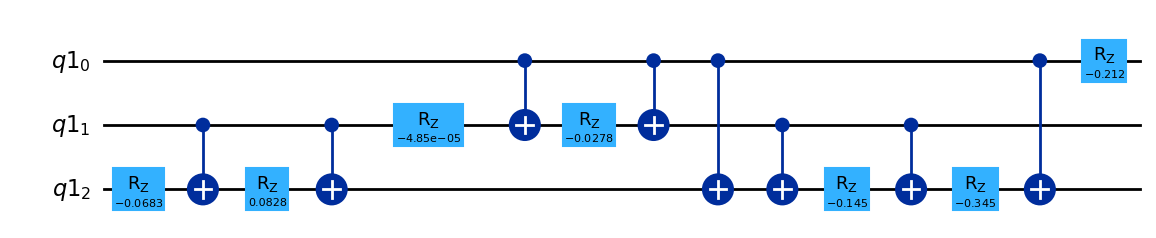

In [8]:
# Test with n_qubits

# Example with random diagonal matrix elements
n_qubits = 3 # Number of qubits
np.random.seed(44)
state = np.random.rand(2**n_qubits) # Random function values

# Calculate Walsh coefficients
coeffs = walsh_coefficients(state, n_qubits)
print("Walsh coefficients:", coeffs)

# Generate and optimize circuit
gates = walsh_circuit_list(coeffs, n_qubits)
gates_opt = optimize_circuit(gates)
circuit = build_circuit(gates_opt, n_qubits)

print("\nOptimized circuit:")
circuit.draw(output="mpl")

## D. Noisy Simulations and Error Mitigation

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import Aer

import numpy as np
from itertools import product

def create_calibration_matrix():
    """Builds a 4x4 measurement error calibration matrix for 2 qubits."""

    cal_circuits = []
    basis_states = [''.join(bits) for bits in product('01', repeat=2)]

    for state in basis_states:
        qc = QuantumCircuit(2, 2)
        for i, bit in enumerate(reversed(state)):  # Little endian
            if bit == '1':
                qc.x(i)
        qc.measure([0, 1], [0, 1])
        cal_circuits.append(qc)

    shots = 100000
    sim = FakeManilaV2()
    results = sim.run(transpile(cal_circuits, sim),shots=shots).result()
    counts = results.get_counts()

    M = np.zeros((4, 4))  # 4 prepared states x 4 measured states
    label_to_index = {label: idx for idx, label in enumerate(basis_states)}

    for i, state in enumerate(basis_states):
        counts = results.get_counts(cal_circuits[i])
        total = sum(counts.values())
        for bitstring, count in counts.items():
            # Ensure all bitstrings are 2 bits
            padded = bitstring.zfill(2)
            j = label_to_index[padded]
            M[j, i] = count / total
    return M, basis_states

def run_noisy_circuit():
    """Runs a 2-qubit Bell circuit that ideally outputs |00⟩ and |11⟩."""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])

    sim = FakeManilaV2()
    shots = 10000
    result = sim.run(transpile(qc, sim),shots=shots).result()
    counts = result.get_counts()

    # Convert counts to probability vector
    p_meas = np.zeros(4)
    index_map = {'00': 0, '01': 1, '10': 2, '11': 3}
    for bitstring, count in counts.items():
        padded = bitstring.zfill(2)
        idx = index_map[padded]
        p_meas[idx] = count / shots

    return p_meas, counts

def apply_correction(M, p_meas):
    """Applies inverse of calibration matrix to correct measured probabilities."""
    M_inv = np.linalg.pinv(M)  # use pseudo-inverse for stability
    p_corrected = np.dot(M_inv, p_meas)
    p_corrected = np.clip(p_corrected, 0, 1)
    return p_corrected / np.sum(p_corrected)

Calibration matrix M:
[[0.9831 0.0277 0.029  0.0006]
 [0.0085 0.9641 0.0002 0.028 ]
 [0.0083 0.0003 0.9622 0.0202]
 [0.0001 0.008  0.0085 0.9512]]

Measured probabilities:
{'00': np.float64(0.4967), '01': np.float64(0.0191), '10': np.float64(0.0168), '11': np.float64(0.4674)}

Corrected probabilities:
{'00': np.float64(0.5048), '01': np.float64(0.0011), '10': np.float64(0.0028), '11': np.float64(0.4913)}


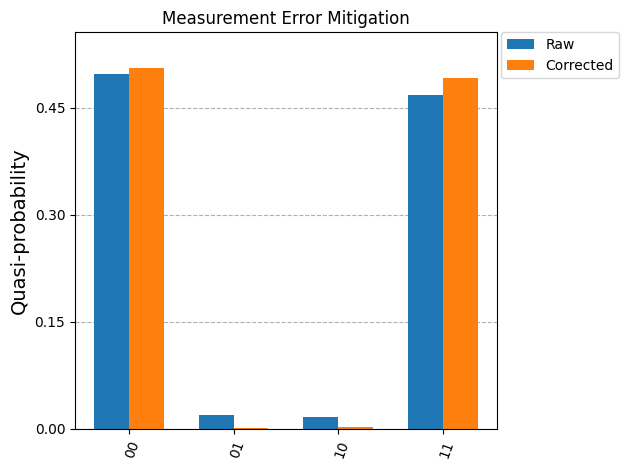

In [10]:
M, state_labels = create_calibration_matrix()
p_meas, raw_counts = run_noisy_circuit()
p_corrected = apply_correction(M, p_meas)

# Display
print("Calibration matrix M:")
print(np.round(M, 4))
print("\nMeasured probabilities:")
print(dict(zip(state_labels, np.round(p_meas, 4))))
print("\nCorrected probabilities:")
print(dict(zip(state_labels, np.round(p_corrected, 4))))

"""
    Plots a comparison between raw and corrected measurement probabilities.

    Args:
        state_labels (List[str]): List of bitstrings for basis states (e.g., ['00', '01', '10', '11']).
        p_meas (np.ndarray): Raw measured probabilities.
        p_corrected (np.ndarray): Corrected probabilities after error mitigation.
    """
raw_dict = dict(zip(state_labels, p_meas))
corrected_dict = dict(zip(state_labels, p_corrected))

plot_histogram(
    [raw_dict, corrected_dict],
    legend=['Raw', 'Corrected'],
    title='Measurement Error Mitigation',
    bar_labels=False
    )